In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#Important keras packages
import keras
from keras import objectives
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Conv2DTranspose, Reshape

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0806 01:47:29.015948 140121742763840 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0806 01:47:29.016801 140121742763840 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0806 01:47:29.017606 140121742763840 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0806 01:47:29.210324 140121742763840 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backen

['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)

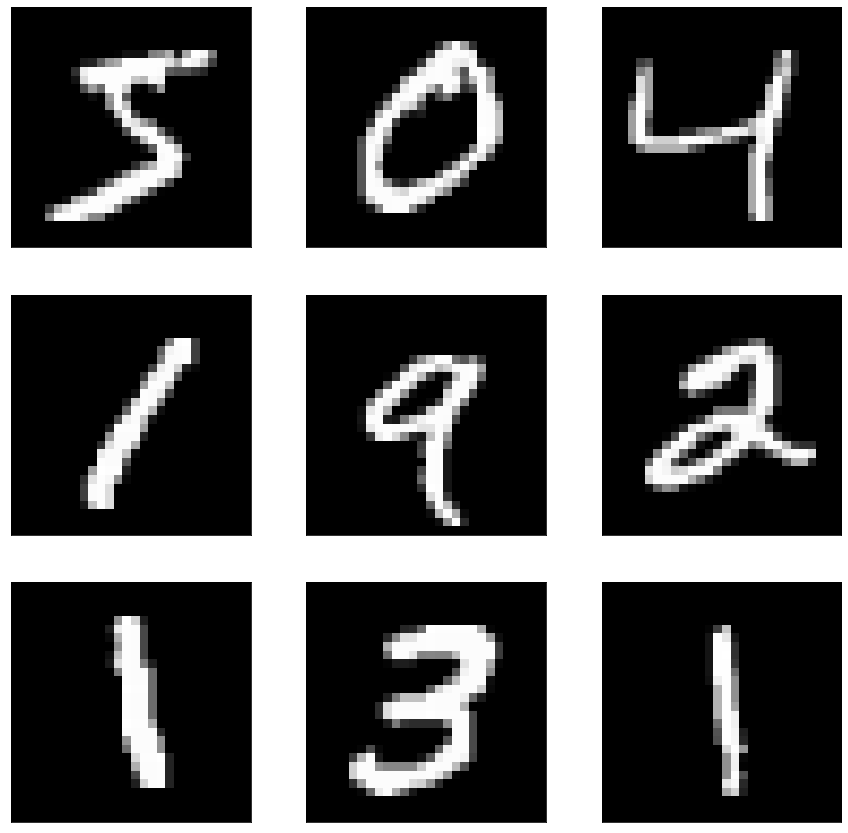

In [3]:
f, axs = plt.subplots(3,3, figsize=(15,15))
ix=0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(x_train[ix].reshape(28,28), cmap='gray')
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        ix+=1
plt.show()

# MLP with two hidden layers

In [4]:
#hyperparameters for the network
n_epoch = 100
n_hidden = 256
z_dim = 10
patience=20
batch_size=100

In [5]:
#reparameterization trick:
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

#Defining the architecture

#Encoder
x = Input(shape=(x_train.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
#Latent space
mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)
z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
#Decoder
x_decoder1 = Dense(n_hidden//2, activation='relu')
x_decoder2 = Dense(n_hidden, activation='relu')
x_decoder3 = Dense(x_train.shape[1], activation='sigmoid')

x_decoded = x_decoder1(z)
x_decoded = x_decoder2(x_decoded)
x_hat = x_decoder3(x_decoded)

W0806 01:47:30.178748 140121742763840 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [6]:
#Defining the loss function
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = objectives.binary_crossentropy(x, x_hat) * x_train.shape[1]
    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    return reconstruction_loss + kl_loss

In [7]:
vae = Model(x, x_hat)

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

W0806 01:47:30.282617 140121742763840 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 01:47:30.305468 140121742763840 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 10)           1290        dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = vae.fit(x_train, x_train,
          shuffle=True,
          epochs=n_epoch,
          batch_size=batch_size,
          validation_data=(x_test, x_test), 
          callbacks= [early_stopping], 
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 65us/step - loss: 162.3697 - val_loss: 130.8926
Epoch 2/100
60000/60000 [==============================] - 2s 37us/step - loss: 122.5753 - val_loss: 116.6930
Epoch 3/100
60000/60000 [==============================] - 2s 37us/step - loss: 113.0069 - val_loss: 109.4643
Epoch 4/100
60000/60000 [==============================] - 2s 37us/step - loss: 108.6543 - val_loss: 106.0412
Epoch 5/100
60000/60000 [==============================] - 2s 37us/step - loss: 105.9717 - val_loss: 103.5809
Epoch 6/100
60000/60000 [==============================] - 2s 37us/step - loss: 104.1358 - val_loss: 102.8388
Epoch 7/100
60000/60000 [==============================] - 2s 38us/step - loss: 102.7145 - val_loss: 102.6215
Epoch 8/100
60000/60000 [==============================] - 2s 38us/step - loss: 101.5943 - val_loss: 100.6240
Epoch 9/100
60000/60000 [==============================] - 2s 37us/ste

60000/60000 [==============================] - 2s 37us/step - loss: 91.3645 - val_loss: 93.8545
Epoch 76/100
60000/60000 [==============================] - 2s 37us/step - loss: 91.2859 - val_loss: 93.8049
Epoch 77/100
60000/60000 [==============================] - 2s 36us/step - loss: 91.2697 - val_loss: 93.4621
Epoch 78/100
60000/60000 [==============================] - 2s 37us/step - loss: 91.2524 - val_loss: 93.1366
Epoch 79/100
60000/60000 [==============================] - 2s 36us/step - loss: 91.2234 - val_loss: 92.9875
Epoch 80/100
60000/60000 [==============================] - 2s 37us/step - loss: 91.1913 - val_loss: 92.8414
Epoch 81/100
60000/60000 [==============================] - 2s 37us/step - loss: 91.1577 - val_loss: 93.6926
Epoch 82/100
60000/60000 [==============================] - 2s 37us/step - loss: 91.1568 - val_loss: 93.9862
Epoch 83/100
60000/60000 [==============================] - 2s 37us/step - loss: 91.1413 - val_loss: 93.2292
Epoch 84/100
60000/60000 [======

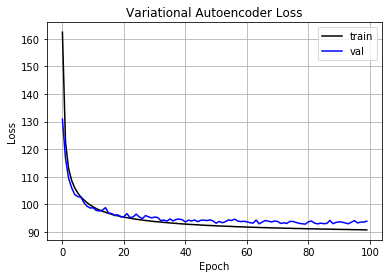

In [9]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='val')
    plt.title('Variational Autoencoder {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

val_loss = history.history['val_loss']
loss = history.history['loss']
plot_loss(loss, val_loss, 'Loss')

In [10]:
x_hat_test = vae.predict(x_test, batch_size=batch_size)

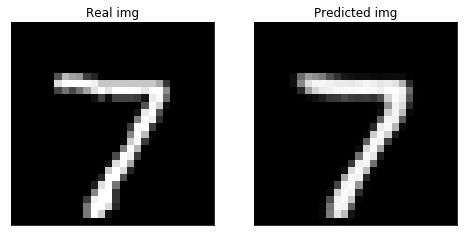

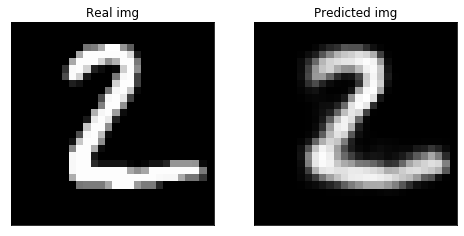

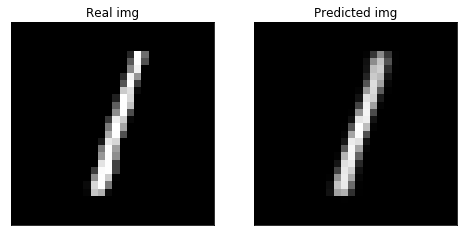

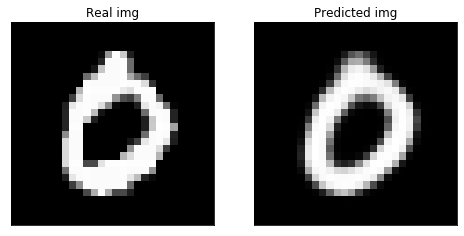

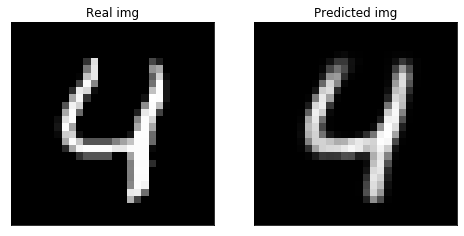

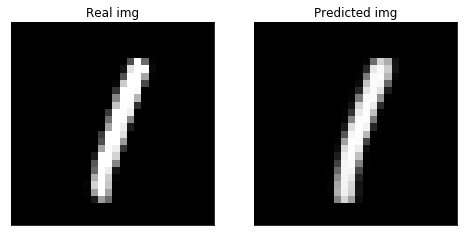

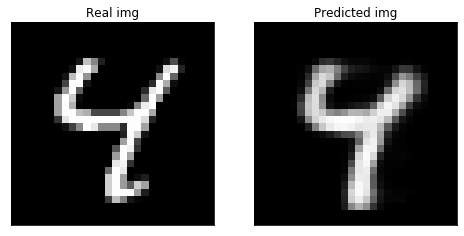

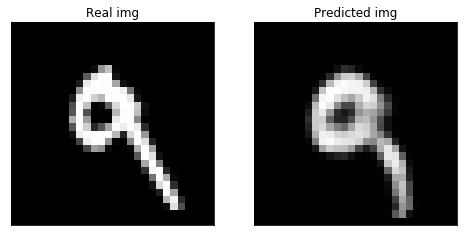

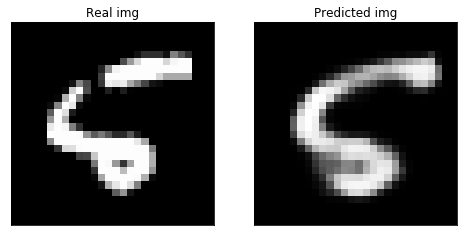

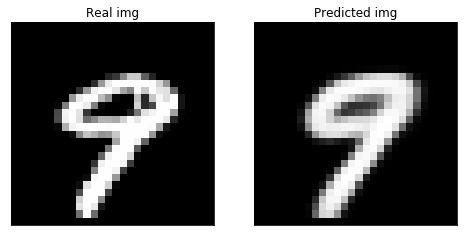

In [11]:
for i in range(10):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.set_title('Real img')
    ax1.imshow(x_test[i].reshape(28,28), cmap='gray')
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax2.set_title('Predicted img')
    ax2.imshow(x_hat_test[i].reshape(28,28), cmap='gray')
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    plt.show()

In [12]:
Encoder = Model(x, z)

z_test = Encoder.predict(x_test, batch_size=batch_size)

In [13]:
#Dimensionality Reduction using t-SNE
z_test_reduced = TSNE(n_components=2).fit_transform(z_test)

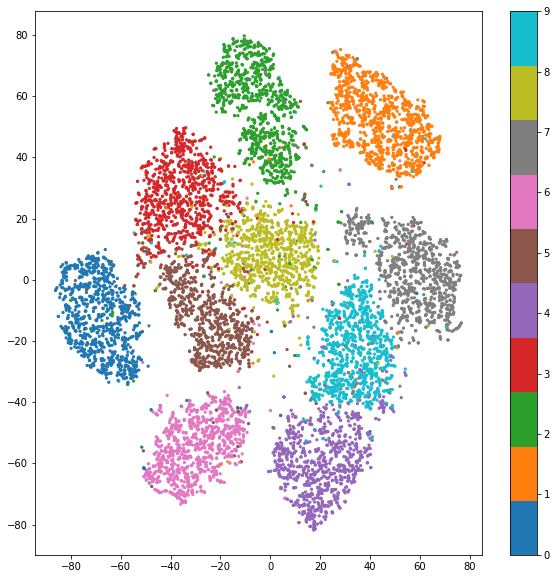

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(z_test_reduced[:, 0], z_test_reduced[:, 1], c=y_test,
            s=20, cmap='tab10', marker='.')
plt.colorbar()
plt.show()

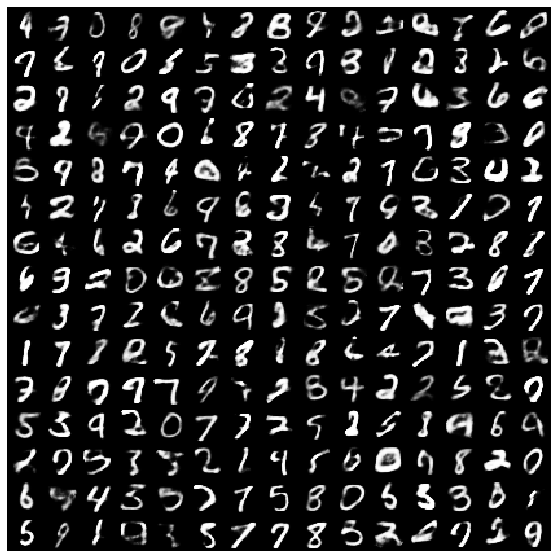

In [15]:
#Deconding from a normally distributed random variable.
decoder_input = Input(shape=(z_dim,))
decoded1 = x_decoder1(decoder_input)
decoded2 = x_decoder2(decoded1)
decoded3 = x_decoder3(decoded2)
Decoder = Model(decoder_input, decoded3)

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n*n):
    z_sample = np.random.normal(loc=0.0, scale=1.0, size=(1, 10,))
    x_decoded = Decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i%n * digit_size: (i%n + 1) * digit_size,
           i//n * digit_size: (i//n + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.show()

# Deep Convolutional Variational Autoencoder (DCVAE)

In [16]:
x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

In [17]:
import cv2

target_size = (32,32) #For the following architecture, we used 32x32 images.
x_train = np.array([cv2.resize(image, dsize=target_size) for image in x_train])
x_test = np.array([cv2.resize(image, dsize=target_size) for image in x_test])
conv_dim=64
z_dim = 10
batch_size = 100

In [18]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

In [19]:
from keras.preprocessing.image import ImageDataGenerator
# As this DCAE uses more GPU capacity, we have to use generators.

datagen = ImageDataGenerator()
generator_train = datagen.flow(x_train, x_train, batch_size=batch_size, shuffle=True)
generator_test = datagen.flow(x_test, x_test, batch_size=batch_size, shuffle=False)

In [20]:
#Encoder
x = Input(shape=(32,32,1))
x_encoded = Conv2D(conv_dim, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x)
x_encoded = Conv2D(conv_dim*2, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_encoded)
x_encoded = Conv2D(conv_dim*4, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_encoded)
x_encoded = Conv2D(conv_dim*8, kernel_size=4, strides=(1,1), padding='same', activation='relu')(x_encoded)
x_encoded = Flatten()(x_encoded)
#Latent space
mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)
z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
#Decoder
x_decoder1 = Dense(4 * 4 * 512)
x_decoder2 = Reshape((4, 4, 512))
x_decoder3 = Conv2DTranspose(conv_dim*8, kernel_size=1, strides=(1,1), padding='same', activation='relu')
x_decoder4 = Conv2DTranspose(conv_dim*4, kernel_size=1, strides=(1,1), padding='same', activation='relu')
x_decoder5 = Conv2DTranspose(conv_dim*2, kernel_size=4, strides=(2,2), padding='same', activation='relu')
x_decoder6 = Conv2DTranspose(conv_dim*1, kernel_size=4, strides=(2,2), padding='same', activation='relu')
x_rec = Conv2DTranspose(1, kernel_size=4, strides=(2,2), padding='same', activation='sigmoid')

x_decoded = x_decoder1(z)
x_decoded = x_decoder2(x_decoded)
x_decoded = x_decoder3(x_decoded)
x_decoded = x_decoder4(x_decoded)
x_decoded = x_decoder5(x_decoded)
x_decoded = x_decoder6(x_decoded)
x_hat = x_rec(x_decoded)

In [21]:
#Defining the loss function
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = objectives.binary_crossentropy(K.flatten(x), K.flatten(x_hat)) * target_size[0] * target_size[1]
    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    return reconstruction_loss + kl_loss

In [22]:
patience=10
dcvae = Model(x, x_hat)
dcvae.compile(optimizer='rmsprop', loss=vae_loss)
dcvae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   1088        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 128)    131200      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 4, 4, 256)    524544      conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
n_epoch=20
history = dcvae.fit_generator(generator_train,
          shuffle=True,
          epochs=n_epoch,
          validation_data=generator_test, 
          callbacks= [early_stopping],
          steps_per_epoch=x_train.shape[0]//batch_size,
          validation_steps=x_test.shape[0]//batch_size,
          verbose=1)

Epoch 1/20
600/600 [==============================] - 9s 16ms/step - loss: 207.3791 - val_loss: 163.9188
Epoch 2/20
600/600 [==============================] - 7s 11ms/step - loss: 155.7157 - val_loss: 150.9519
Epoch 3/20
600/600 [==============================] - 7s 11ms/step - loss: 147.4326 - val_loss: 142.8419
Epoch 4/20
600/600 [==============================] - 7s 11ms/step - loss: 143.1295 - val_loss: 140.8375
Epoch 5/20
600/600 [==============================] - 7s 11ms/step - loss: 140.5559 - val_loss: 141.1505
Epoch 6/20
600/600 [==============================] - 7s 12ms/step - loss: 138.6672 - val_loss: 138.0278
Epoch 7/20
600/600 [==============================] - 7s 11ms/step - loss: 137.2775 - val_loss: 136.5187
Epoch 8/20
600/600 [==============================] - 7s 12ms/step - loss: 136.1625 - val_loss: 135.5517
Epoch 9/20
600/600 [==============================] - 7s 11ms/step - loss: 135.3293 - val_loss: 135.9657
Epoch 10/20
600/600 [==============================] - 

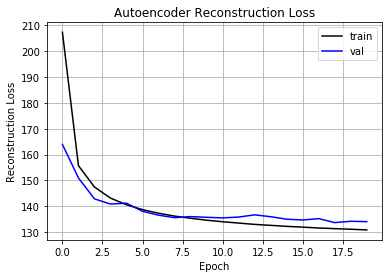

In [24]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='val')
    plt.title('Autoencoder {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

val_loss = history.history['val_loss']
loss = history.history['loss']
plot_loss(loss, val_loss, 'Reconstruction Loss')

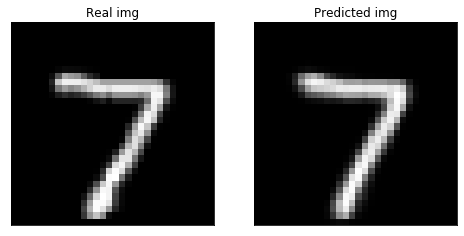

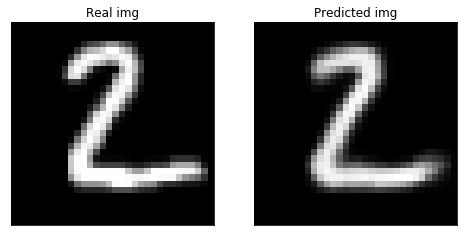

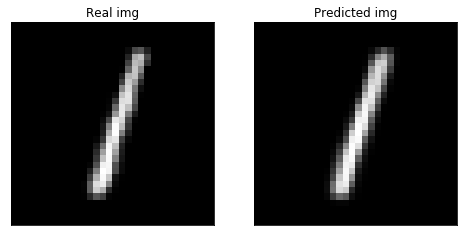

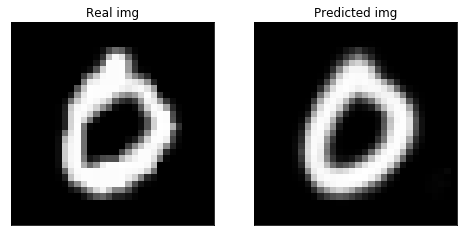

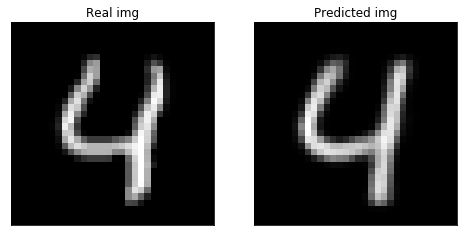

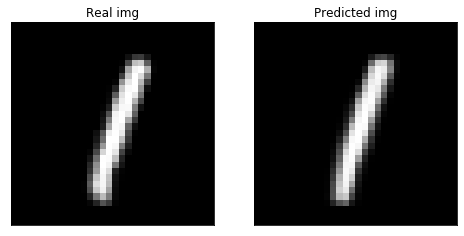

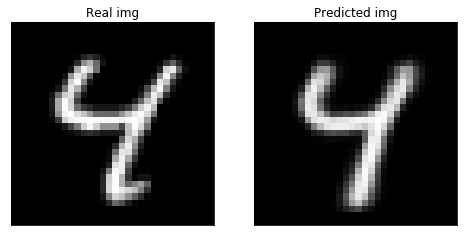

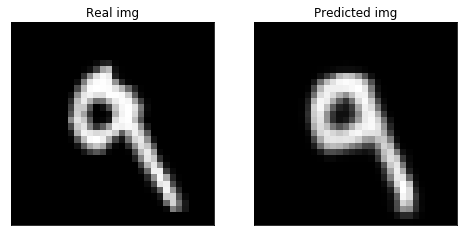

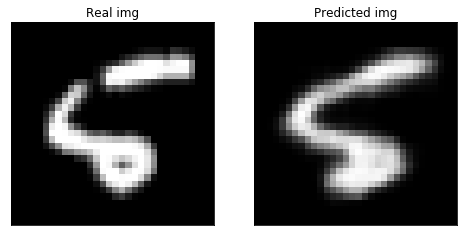

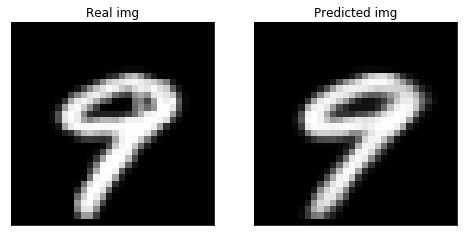

In [25]:
x_hat_test = dcvae.predict(x_test, batch_size=batch_size)

for i in range(10):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.set_title('Real img')
    ax1.imshow(x_test[i, :, :, 0], cmap='gray')
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax2.set_title('Predicted img')
    ax2.imshow(x_hat_test[i, :, :, 0], cmap='gray')
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    plt.show()

In [26]:
Encoder = Model(x, z)

z_test = Encoder.predict(x_test, batch_size=batch_size)
z_test_reduced = TSNE(n_components=2).fit_transform(z_test)

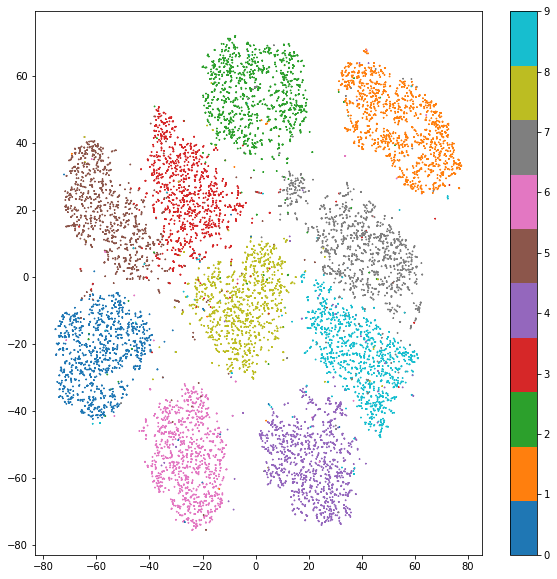

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(z_test_reduced[:, 0], z_test_reduced[:, 1], c=y_test,
            s=1, cmap='tab10', marker='*')
plt.colorbar()
plt.show()

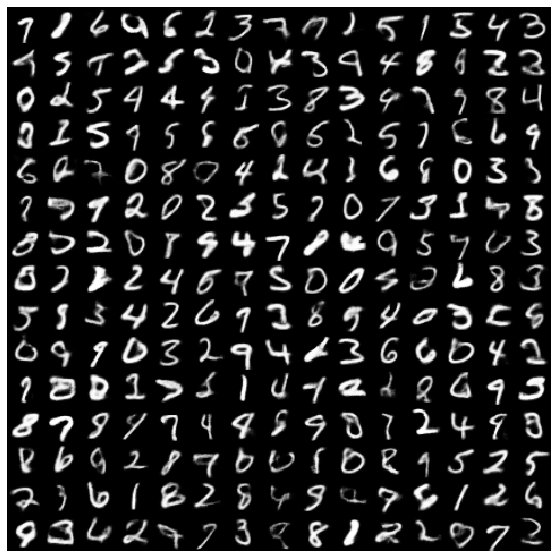

In [28]:
decoder_input = Input(shape=(z_dim,))
decoded1 = x_decoder1(decoder_input)
decoded2 = x_decoder2(decoded1)
decoded3 = x_decoder3(decoded2)
decoded4 = x_decoder4(decoded3)
decoded5 = x_decoder5(decoded4)
decoded6 = x_decoder6(decoded5)
x_hat = x_rec(decoded6)
Decoder = Model(decoder_input, x_hat)

n = 15  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n*n):
    z_sample = np.random.normal(loc=0.0, scale=1.0, size=(1, 10,))
    x_decoded = Decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i%n * digit_size: (i%n + 1) * digit_size,
           i//n * digit_size: (i//n + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.show()